In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline


In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import glob
import sys
import random
from argparse import ArgumentParser
import time
import pickle

# third-party imports
import tensorflow as tf
import numpy as np
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import Adam
from keras.models import load_model, Model
from keras.losses import mean_squared_error
import keras.backend as K
from neuron.plot import slices
import scipy.io as sio
from scipy.interpolate import interpn
import matplotlib.pyplot as plt
import nibabel as nib


# project imports
sys.path.append('../ext/medipy-lib')
import medipy
import networks
from medipy.metrics import dice
import datagenerators
import losses
from restrict import restrict_GPU_tf, restrict_GPU_keras

Using TensorFlow backend.


In [3]:
def restrict_GPU_tf(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        tf.Session(config=config)
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [4]:
# Keras 
def restrict_GPU_keras(gpuid, memfrac=0, use_cpu=False):
    """
        gpuid: str, comma separated list "0" or "0,1" or even "0,1,3"
        memfrac: float, fraction of memory. By default grows dynamically
    """
    if not use_cpu:
        os.environ["CUDA_VISIBLE_DEVICES"] = gpuid

        config = tf.ConfigProto()
        if memfrac == 0:
            config.gpu_options.allow_growth = True
        else:
            config.gpu_options.per_process_gpu_memory_fraction = memfrac
        set_session(tf.Session(config=config))
        print("Using GPU:{} with {:.0f}% of the memory".format(gpuid, memfrac*100))
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = ""
        print("Using CPU")

In [6]:
def test_model(model_name, iter_num, gpu_id, vol, seg, max_clip=0.7):    
    good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
    
    # setup
    gpu = '/gpu:' + str(gpu_id)
    #     print(gpu)
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

    restrict_GPU_tf(str(gpu_id))
    restrict_GPU_keras(str(gpu_id))

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config.allow_soft_placement = True
    set_session(tf.Session(config=config))

    vol_size=(160,192,224)
    nf_enc=[16,32,32,32]
    nf_dec=[32,32,32,32,32,16,16]
    
    atlas_vol = nib.load('../data/t2_atlas_027_S_2219.nii').get_data()[np.newaxis,...,np.newaxis]
    atlas_seg = nib.load('../data/t2_atlas_seg_027_S_2219.nii').get_data()
    
    atlas_vol = atlas_vol/np.max(atlas_vol) * max_clip

    sz = atlas_seg.shape
    z_inp1 = tf.placeholder(tf.float32, sz)
    z_inp2 = tf.placeholder(tf.float32, sz)
    z_out = losses.kdice(z_inp1, z_inp2, good_labels)
    kdice_fn = K.function([z_inp1, z_inp2], [z_out])

    nn_trf_model = networks.nn_trf(vol_size)

    # load weights of model
    with tf.device(gpu):
        net = networks.cvpr2018_net(vol_size, nf_enc, nf_dec)
        net.load_weights('../models/' + model_name +
                         '/' + str(iter_num) + '.h5')

        pred = net.predict([vol, atlas_vol])
        warp_seg = nn_trf_model.predict([seg, pred[1]])
        dice = kdice_fn([warp_seg[0,:,:,:,0], atlas_seg])
        print('dice', np.mean(dice))
        return dice, pred[0][0,:,:,:,0], warp_seg[0,:,:,:,0], pred[1][0,:,:,:,0]



In [14]:
model_name = 'mind_d2p3l0001'
num_iters = 600
gpu_id = 3
vol = nib.load("../t1_atlas.nii").get_data()[np.newaxis,:,:,:,np.newaxis]
seg = nib.load("../t1_atlas_seg.nii").get_data()[np.newaxis,:,:,:,np.newaxis]
dices, warped, warped_seg, flow = test_model(model_name, num_iters, gpu_id, vol, seg)

Using GPU:3 with 0% of the memory
Using GPU:3 with 0% of the memory
dice 0.58974826


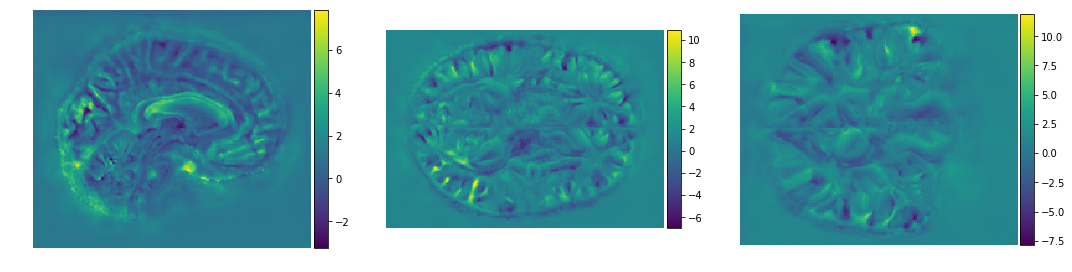

(<matplotlib.figure.Figure at 0x7f8d1871bc50>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cf00ee940>,
       dtype=object))

In [15]:
slices([flow[80,:,:], flow[:,90,:], flow[:,:,100]], do_colorbars=True, cmaps=['viridis', 'viridis', 'viridis'])

In [8]:
nii = nib.Nifti1Image(warped, np.eye(4))
nib.save(nii, '../test_mind.nii')
nii = nib.Nifti1Image(warped_seg, np.eye(4))
nib.save(nii, '../test_mind_seg.nii')